In [1]:
import os

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from dotenv import load_dotenv
load_dotenv()

import mlflow

mlflow.set_tracking_uri(os.getenv('MLFLOW_URL'))

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor

In [2]:
targets = {
    'GENERATOR': ['Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg','Gen_SlipRing_Temp_Avg',],
    'HYDRAULIC_GROUP': ['Hyd_Oil_Temp_Avg'],
    'GENERATOR_BEARING': ['Gen_Bear_Temp_Avg','Gen_Bear2_Temp_Avg'],
    'TRANSFORMER': ['HVTrafo_Phase1_Temp_Avg','HVTrafo_Phase2_Temp_Avg','HVTrafo_Phase3_Temp_Avg'],
    'GEARBOX': ['Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg']
    }

features = ['Gen_RPM_Avg', 'Nac_Temp_Avg','Rtr_RPM_Avg', 'Amb_WindSpeed_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_TotReactPwr',
       'Spin_Temp_Avg', 'Blds_PitchAngle_Avg', 'Grd_Busbar_Temp_Avg','Nac_Direction_Avg', 'theoretical_performance_ratio']

In [24]:
def load_failures() -> pd.DataFrame:
    """Load the failures from the wind farm dataset."""
    df = pd.read_csv('../data/raw/htw-failures-2016.csv', sep=';')
    aux = pd.read_csv('../data/raw/htw-failures-2017.csv', sep=';')

    df = pd.concat([df, aux], axis=0).reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp').sort_index()
    df = df[df.Turbine_ID != 'T09']
    df['Turbine_ID'] = df['Turbine_ID'].apply(lambda x: int(x[1:]))
    return df

def trb_per_failures() -> dict:
    """Return a dictionary with the turbine ID per component failure"""
    failures = load_failures()
    trb_per_comp = {}
    for comp in failures.Component.unique():
        trb_per_comp[comp] = failures[failures.Component == comp].Turbine_ID.unique().tolist()
    return trb_per_comp

def create_time_columns(df) -> pd.DataFrame:
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

In [26]:
for id in [1, 6, 7, 11]:
    for comp in targets.keys():
        if id not in trb_per_failures()[comp]:
            continue
        for col in targets[comp]:
            MODULE_NAME = os.getenv('MODULE_NAME')
            # Start mlflow run
            with mlflow.start_run(run_name=f'{MODULE_NAME}_trb{id}_{col}') as run:
                # Set tags
                mlflow.set_tags({
                    'MODULE': MODULE_NAME,
                    'trb_num': id,
                    'col': col,
                    'model': 'XGBRegressor'
                })

                # Load train/test datasets
                train = pd.read_parquet(f'../data/processed/{id}/train.parquet')

                # Select the target variable
                y_train = train.pop(col)

                # Select the features to be used in the model
                train = train[features]
                train = create_time_columns(train)

                # Split the train dataset into train and validation
                X_train, X_val, y_train, y_val = train_test_split(train, y_train, test_size=0.2, random_state=42)

                # Scale the features
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)

                # Select the parameters for XGBRegressor model
                params = {
                    'n_estimators': 1000,
                    'max_depth': 6,
                    'min_child_weight': 1,
                    'gamma': 0,
                    'learning_rate': 0.01,
                    'objective': 'reg:squarederror',
                }
                mlflow.log_params(params)

                # Train the model
                model = XGBRegressor(**params)
                model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], early_stopping_rounds=50, verbose=False)

                # Save the scaler and model into mflow
                mlflow.sklearn.log_model(scaler, 'scaler')
                mlflow.xgboost.log_model(model, 'model')

                # Evaluate the model
                y_pred = model.predict(X_val_scaled)
                mlflow.log_metrics({
                    'rmse': np.sqrt(mean_squared_error(y_val, y_pred)),
                    'mae': mean_absolute_error(y_val, y_pred),
                    'r2': r2_score(y_val, y_pred)
                })

                X_val = pd.DataFrame(X_val, columns=features + ['month', 'day', 'hour', 'dayofweek'])
                X_val['y_true'] = y_val
                X_val['y_pred'] = y_pred
                X_val['residual'] = y_val - y_pred

                threshold = {
                    'mean': str(X_val['residual'].mean()),
                    'median': str(X_val['residual'].median()),
                    'std': str(X_val['residual'].std()),
                    'mad': str((X_val['residual'] - X_val['residual'].median()).abs().median())
                }
                # Save json
                with open(f'../data/interim/threshold.json', 'w') as f:
                    json.dump(threshold, f)

                mlflow.log_artifact(f'../data/interim/threshold.json')

                # Get costs metric
                break
            break
        break
    break

2023/08/07 09:51:45 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [42]:
test = pd.read_parquet(f'../data/processed/{id}/test.parquet')

y_test = test.pop(col)

# Select the features to be used in the model
test = test[features]
test = create_time_columns(test)

X_test_scaled = scaler.transform(test)

test[col] = y_test
test['y_pred'] = model.predict(X_test_scaled)
test['residual'] = test[col] - test['y_pred']

test = test[[col, 'y_pred', 'residual']]

alarms = test.copy()
alarms = alarms.resample('12H').mean()
alarms['anomalous_pred'] = np.where(
    (alarms['residual'] >=  float(threshold['median']) + 3 * float(threshold['std']))|(alarms['residual'] <=  float(threshold['median']) - 3 * float(threshold['std'])),
    1,
    0
)
failures = load_failures()
dates = failures[(failures['Turbine_ID'] == id) & (failures['Component'] == comp)].index

init = True
for date in dates:
    if init:
        alarms['anomalous_real'] = np.where(
            (alarms.index >= date - pd.Timedelta(days=90)) & (alarms.index <= date),
            1,
            0
        )
        init = False
    else:
        alarms['anomalous_real'] = np.where(
            (alarms.index >= date - pd.Timedelta(days=90)) & (alarms.index <= date),
            1,
            alarms['anomalous_real']
        )

alarms[['anomalous_real', 'anomalous_pred']].plot(figsize=(15, 5), title=f'Anomalous Real vs Anomalous Predicted (turbine {id}, column {col})')
for date in dates:
    plt.axvline(x=date, color='red', linestyle='--')
plt.show()



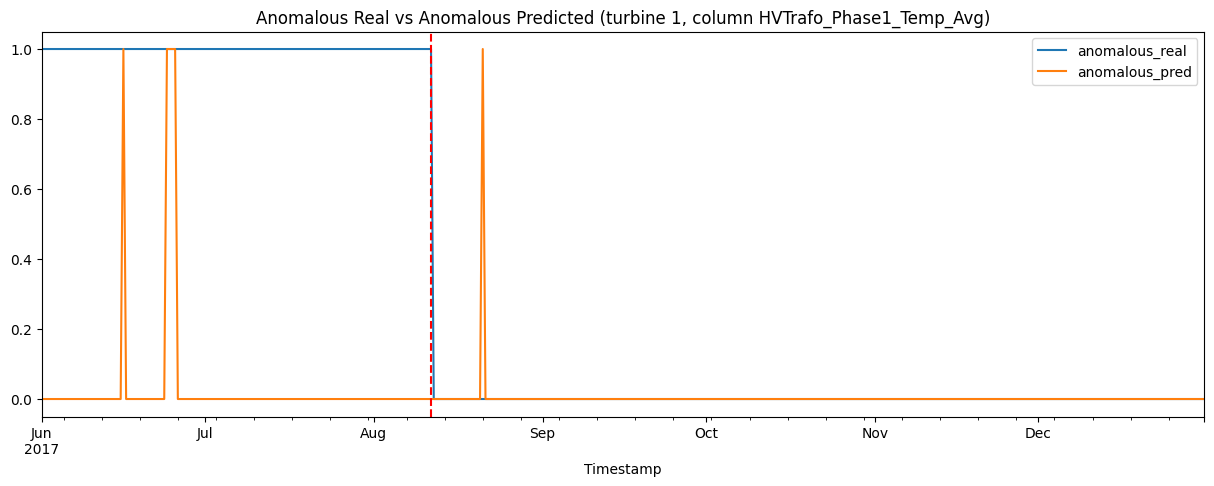

In [56]:
alarms[['anomalous_real', 'anomalous_pred']].plot(figsize=(15, 5), title=f'Anomalous Real vs Anomalous Predicted (turbine {id}, column {col})')
for date in dates:
    plt.axvline(x=date, color='red', linestyle='--')


In [54]:
alarms[(alarms['anomalous_real']&alarms['anomalous_pred']) == 1].index[0]

Timestamp('2017-06-16 00:00:00+0000', tz='UTC')